In [1]:
# import statements
import pandas as pd
import numpy as np
import re
import seaborn as sns

from zipfile import ZipFile
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inlineIPython (Interactive Python) is a command shell for interactive computing in multiple programming languages, originally developed for the Python programming language, that offers introspection, rich media, shell syntax, tab completion, and history. IPython provides the following features:

import warnings
warnings.filterwarnings(action='ignore')

UsageError: unrecognized arguments: (Interactive Python) is a command shell for interactive computing in multiple programming languages, originally developed for the Python programming language, that offers introspection, rich media, shell syntax, tab completion, and history. IPython provides the following features:


In [ ]:
# load and preview training data
with ZipFile('train.csv.zip') as zf:
    with zf.open('train.csv') as f:
        train_data = pd.read_csv(f)

train_data.head()

In [ ]:
# basic DataFrame info
train_data.info()

In [ ]:
# missing values in original data
print(train_data.isnull().sum(), '\n')
print(train_data.isnull().sum() / train_data.shape[0] * 100, "\n")

# Removing redundency in department description column
print(train_data.DepartmentDescription.unique(), '\n')
train_data = train_data.replace('MENS WEAR', 'MENSWEAR')
print(train_data.DepartmentDescription.unique(), '\n')

In [ ]:
# visit is an identifier variable, each value will be an observation in final dataset.
train_data.drop_duplicates()

# are upc and FinelineNumber always missing together?
upc_null = train_data.Upc.isnull()
print('% of UPC and FinelineNumber values missing together:', 
      train_data.FinelineNumber[upc_null].isnull().mean() * 100, '\n')

# what are the values of dept when upc/FinelineNumber are missing?
print("Departments of missing items:", 
      train_data.DepartmentDescription[upc_null].unique(), '\n')

# when dept is missing, are both upc and FinelineNumber missing?
dept_null = train_data.DepartmentDescription.isnull()

# only need to test one of upc and FinelineNumber
print("% of upc/FinelineNumber values missing when dept is missing:",
      train_data.Upc[dept_null].isnull().mean() * 100)

In [ ]:
# drop NA values
train_data =  train_data.dropna()

In [ ]:
# basic DataFrame info after dropna()
train_data.info()

In [ ]:
sample = train_data[['TripType', 'DepartmentDescription']]

sample = pd.crosstab(index = train_data.TripType,
                     columns = train_data.DepartmentDescription,
                     rownames = ['TripType'],
                     colnames = ['DepartmentDescription'],
                     margins = False)

sample

In [ ]:
fig, ax = plt.subplots(figsize = (20,18))
sns.heatmap(ax = ax, data = sample)

## Feature Engineering & Data Preparation

In [ ]:
#Feature Building
def data_generator(data):
    
    data = train_data.copy()
    dummies = pd.get_dummies(data.DepartmentDescription)
    data[dummies.columns] = dummies
    data_dummies = data.iloc[:, 7:]
    data_dummies = data_dummies.apply(lambda n: n * data['ScanCount'])

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    data = data[['TripType', 'VisitNumber', 'Weekday', 'ScanCount', 'Return']]
    data = data.rename(columns = {"ScanCount": 'NumItems'})
    data = pd.concat([data, data_dummies], axis = 1)

    grouped = data.groupby("VisitNumber")
    grouped = grouped.agg({'Weekday': np.max, "TripType": np.max, 
                           'NumItems': np.sum, 'Return': np.max, 
                           '1-HR PHOTO': np.sum, 'ACCESSORIES': np.sum, 
                           'AUTOMOTIVE': np.sum, 'BAKERY': np.sum, 
                           'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 
                           'BEDDING': np.sum, 'BOOKS AND MAGAZINES': np.sum, 
                           'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum, 
                           'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 
                           'CELEBRATION': np.sum, 'COMM BREAD': np.sum, 
                           'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 
                           'DAIRY': np.sum, 'DSD GROCERY': np.sum, 
                           'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 
                           'FINANCIAL SERVICES': np.sum, 'FROZEN FOODS': np.sum, 
                           'FURNITURE': np.sum, 'GIRLS WEAR, 4-6X  AND 7-14': np.sum, 
                           'GROCERY DRY GOODS': np.sum, 'HARDWARE': np.sum, 
                           'HEALTH AND BEAUTY AIDS': np.sum, 'HOME DECOR': np.sum, 
                           'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum, 
                           'HOUSEHOLD CHEMICALS/SUPP': np.sum,
                           'HOUSEHOLD PAPER GOODS': np.sum, 'IMPULSE MERCHANDISE': np.sum, 
                           'INFANT APPAREL': np.sum, 'INFANT CONSUMABLE HARDLINES': np.sum,
                           'JEWELRY AND SUNGLASSES': np.sum, 'LADIES SOCKS': np.sum, 
                           'LADIESWEAR': np.sum, 'LARGE HOUSEHOLD GOODS': np.sum, 
                           'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum, 
                           'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum,
                           'MENSWEAR': np.sum, 'OFFICE SUPPLIES': np.sum, 
                           'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
                           'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 
                           'PERSONAL CARE': np.sum, 'PETS AND SUPPLIES': np.sum, 
                           'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum, 
                           'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 
                           'PRE PACKED DELI': np.sum, 'PRODUCE': np.sum, 
                           'SEAFOOD': np.sum, 'SEASONAL': np.sum, 
                           'SERVICE DELI': np.sum, 'SHEER HOSIERY': np.sum, 
                           'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 
                           'SPORTING GOODS': np.sum, 'SWIMWEAR/OUTERWEAR': np.sum, 
                           'TOYS': np.sum, 'WIRELESS': np.sum})
    
    data = grouped[["TripType", "Weekday", "NumItems", "Return",'1-HR PHOTO', 
                    'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 
                    'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR', 'CAMERAS AND SUPPLIES', 
                    'CANDY, TOBACCO, COOKIES', 'CELEBRATION', 'COMM BREAD', 'CONCEPT STORES', 
                    'COOK AND DINE', 'DAIRY', 'DSD GROCERY', 'ELECTRONICS', 'FABRICS AND CRAFTS', 
                    'FINANCIAL SERVICES', 'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14', 
                    'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS', 'HOME DECOR', 
                    'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS','HOUSEHOLD CHEMICALS/SUPP', 
                    'HOUSEHOLD PAPER GOODS', 'IMPULSE MERCHANDISE', 'INFANT APPAREL', 
                    'INFANT CONSUMABLE HARDLINES','JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 
                    'LADIESWEAR', 'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER', 
                    'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR', 'OFFICE SUPPLIES', 
                    'OPTICAL - FRAMES', 'OPTICAL - LENSES', 'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 
                    'PERSONAL CARE','PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX', 
                    'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY','PRE PACKED DELI', 'PRODUCE', 
                    'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY', 'SHOES', 
                    'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS', 'SWIMWEAR/OUTERWEAR','TOYS', 'WIRELESS']]
#     data.head()
    return data

train_data = data_generator(train_data)
print(train_data.shape)
train_data

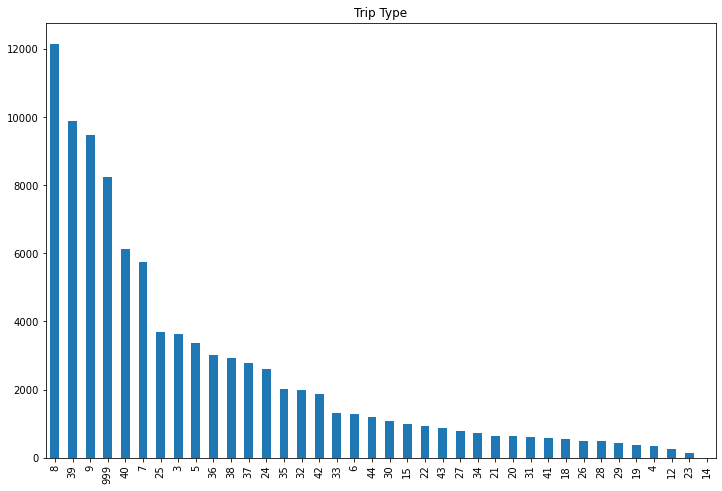

In [11]:
#ploting the bar chart for the trip types 
plt.figure(figsize = (12, 8))
train_data['TripType'].value_counts().plot(kind = 'bar', title = 'Trip Type')

There is a significant class imbalance in terms of predicting object, TripType. So eliminating extremely popular trip types and unpopular trip types to balance classes better.

In [12]:
# show data descriptions
train_data = train_data[train_data.TripType.isin([25, 3, 5, 36, 38, 37, 24, 35, 32])]
train_data.describe()

,TripType,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,...,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000
mean,24.557519,7.899674,0.052468,0.001306,0.010563,0.020280,0.076743,0.085577,0.234722,0.054888,...,0.015710,0.000192,0.064721,0.005147,0.045016,0.043211,0.017976,0.014788,0.028308,0.002458
std,13.385487,8.460352,0.222973,0.066160,0.142963,0.209009,0.393476,0.798115,1.035118,0.461824,...,0.176234,0.016396,0.352884,0.134264,0.305593,0.375683,0.195359,0.194148,0.249924,0.058745
min,3.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,38.000000,311.000000,1.000000,7.000000,7.000000,10.000000,12.000000,67.000000,45.000000,18.000000,...,7.000000,2.000000,8.000000,10.000000,12.000000,18.000000,12.000000,8.000000,10.000000,4.000000


In [13]:
# show the mean of bottom 20 departments
train_data.mean().sort_values().head(20)

HEALTH AND BEAUTY AIDS     0.000038
CONCEPT STORES             0.000077
OTHER DEPARTMENTS          0.000115
SEASONAL                   0.000192
CAMERAS AND SUPPLIES       0.000576
1-HR PHOTO                 0.001306
PLAYERS AND ELECTRONICS    0.001767
WIRELESS                   0.002458
LARGE HOUSEHOLD GOODS      0.002919
OPTICAL - LENSES           0.003342
SHEER HOSIERY              0.005147
BOOKS AND MAGAZINES        0.006683
MEDIA AND GAMING           0.006722
PHARMACY RX                0.006799
ELECTRONICS                0.007413
PAINT AND ACCESSORIES      0.008258
ACCESSORIES                0.010563
HORTICULTURE AND ACCESS    0.010716
LADIES SOCKS               0.011792
PLUS AND MATERNITY         0.012022
dtype: float64

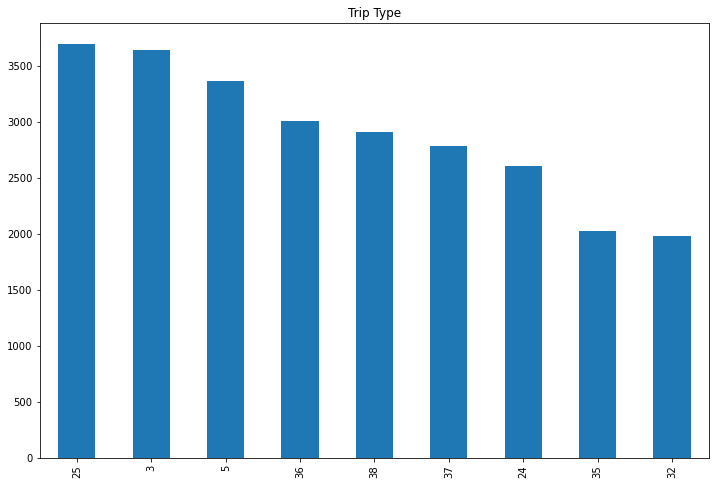

In [14]:
# ploting the bar chart for the trip types 
plt.figure(figsize=(12,8))
train_data['TripType'].value_counts().plot(kind = 'bar', title = 'Trip Type')

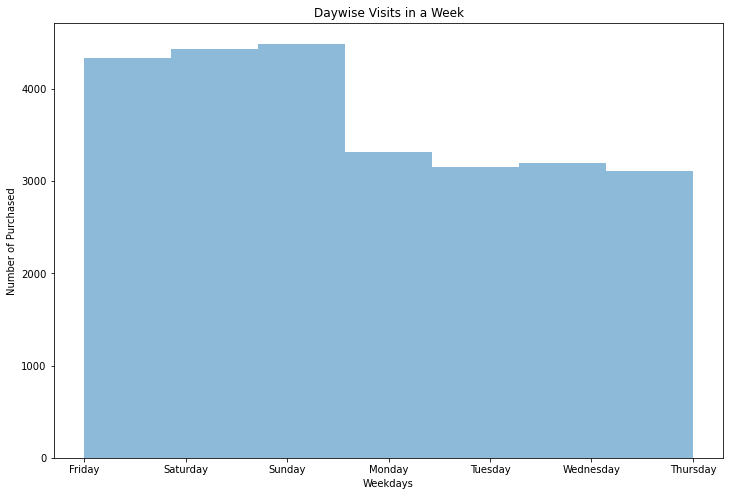

In [15]:
# ploting histogram for daywise visits
plt.figure(figsize=(12,8))
num_bins = 7
n, bins, patches = plt.hist(train_data['Weekday'], num_bins, alpha = 0.5)
plt.xlabel('Weekdays')
plt.ylabel('Number of Purchased')
plt.title("Daywise Visits in a Week")
plt.show()

In [16]:
# apply label encoder to transform categorical data Weekday
label_encoder = LabelEncoder()
train_data.Weekday = label_encoder.fit_transform(np.array(train_data.Weekday))
train_data

,TripType,Weekday,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
11,35,0,4,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,25,0,8,0.0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
43,38,0,4,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,35,0,5,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,36,0,5,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191326,38,3,11,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191329,24,3,20,0.0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
191335,32,3,9,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Test & Train Split

In [17]:
# Data preprocesssing dropping na and splitting data into test and train
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['TripType',
                                                                     'HEALTH AND BEAUTY AIDS',
                                                                     'CONCEPT STORES',
                                                                     'OTHER DEPARTMENTS',
                                                                     'SEASONAL',
                                                                     'CAMERAS AND SUPPLIES',
                                                                     '1-HR PHOTO'], 
                                                                    axis = 'columns').values,
                                                    train_data.TripType.values,
                                                    train_size = 0.8,
                                                    random_state = 999)

In [18]:
# show data shape
print(X_train.shape, '\n')
print(X_test.shape, '\n')
print(y_train.shape, '\n')
print(y_test.shape, '\n')

(20828, 64) 

(5207, 64) 

(20828,) 

(5207,) 



In [19]:
# show data with cleaned features
features_cleaned = train_data.drop(['TripType',
                                    'HEALTH AND BEAUTY AIDS',
                                    'CONCEPT STORES',
                                    'OTHER DEPARTMENTS',
                                    'SEASONAL',
                                    'CAMERAS AND SUPPLIES',
                                    '1-HR PHOTO'], 
                                   axis = 'columns').columns.values
len(features_cleaned)

64

## Modeling

### Supervised Learning - Logistic Regression

In [20]:
lr = LogisticRegression(C = 1, penalty = 'l2', tol = 1e-4, solver = 'saga')
lr = lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)

#### Accuracy of Logistic Regression

In [21]:
print("The accuracy of Logistic Regression prediction is", '{:.2%}'.format(accuracy_score(y_test, lr_predictions)))

The accuracy of Logistic Regression prediction is 87.08%


#### Summarization of feature importance

In [22]:
importance = lr.coef_[0]
importance_score = []

for i, v in enumerate(importance):
    importance_score.append(v)
    
importance_table = pd.DataFrame([features_cleaned, importance_score]).T
importance_table.columns = ['features_cleaned', 'importance_score']
importance_table = importance_table.sort_values('importance_score')
importance_table

,features_cleaned,importance_score
1,NumItems,-0.42012
49,PHARMACY OTC,-0.327489
17,DSD GROCERY,-0.291853
47,PERSONAL CARE,-0.225593
54,PRODUCE,-0.215353
...,...,...
18,ELECTRONICS,0.00452376
37,LARGE HOUSEHOLD GOODS,0.0934588
0,Weekday,0.173167
31,IMPULSE MERCHANDISE,0.320258


#### Log Loss of Logistic Regression

In [23]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(y_test, lr.predict_proba(X_test))))

The log loss of Logistic Regression prediction is 0.56


#### Confusion Matrix on Logistic Regression

In [24]:
pd.crosstab(index = y_test,
            columns = lr_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,711,1,0,1,0,14,1,2,0
5,1,598,7,3,1,5,22,7,9
24,13,17,384,15,1,11,19,13,12
25,3,16,2,691,4,10,18,12,9
32,5,2,5,10,323,14,14,1,14
35,0,7,6,3,1,320,5,15,36
36,5,40,10,13,4,5,527,7,9
37,2,8,11,1,2,13,4,479,37
38,4,9,12,5,3,35,16,31,501


#### Classification Report on Logistic Regression

In [25]:
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

           3       0.96      0.97      0.96       730
           5       0.86      0.92      0.89       653
          24       0.88      0.79      0.83       485
          25       0.93      0.90      0.92       765
          32       0.95      0.83      0.89       388
          35       0.75      0.81      0.78       393
          36       0.84      0.85      0.85       620
          37       0.84      0.86      0.85       557
          38       0.80      0.81      0.81       616

    accuracy                           0.87      5207
   macro avg       0.87      0.86      0.86      5207
weighted avg       0.87      0.87      0.87      5207



C=1.0000
Sparsity with L1 penalty:                3.12%
Sparsity with L2 penalty:                0.00%
Sparsity with Elastic-Net penalty:       0.69%
Score with L1 penalty:                   0.87
Score with L2 penalty:                   0.87
Score with Elastic-Net penalty:          0.87 

The accuracy of penalty = L1 and C = 1 is 87.09% 

The log loss of Logistic Regression prediction is 0.56 

              precision    recall  f1-score   support

           3       0.96      0.97      0.96       730
           5       0.86      0.92      0.89       653
          24       0.88      0.79      0.83       485
          25       0.93      0.90      0.92       765
          32       0.95      0.83      0.89       388
          35       0.75      0.82      0.78       393
          36       0.84      0.85      0.85       620
          37       0.84      0.86      0.85       557
          38       0.80      0.81      0.81       616

    accuracy                           0.87      5207
   mac

C=0.0010
Sparsity with L1 penalty:                95.83%
Sparsity with L2 penalty:                0.00%
Sparsity with Elastic-Net penalty:       94.10%
Score with L1 penalty:                   0.77
Score with L2 penalty:                   0.85
Score with Elastic-Net penalty:          0.82 

The accuracy of penalty = L1 and C = 0.001 is 78.32% 

The log loss of Logistic Regression prediction is 0.98 

              precision    recall  f1-score   support

           3       0.85      0.94      0.90       730
           5       0.74      0.86      0.79       653
          24       0.64      0.55      0.59       485
          25       0.86      0.73      0.79       765
          32       0.95      0.72      0.82       388
          35       0.73      0.74      0.73       393
          36       0.78      0.83      0.80       620
          37       0.76      0.79      0.78       557
          38       0.74      0.77      0.76       616

    accuracy                           0.78      5207


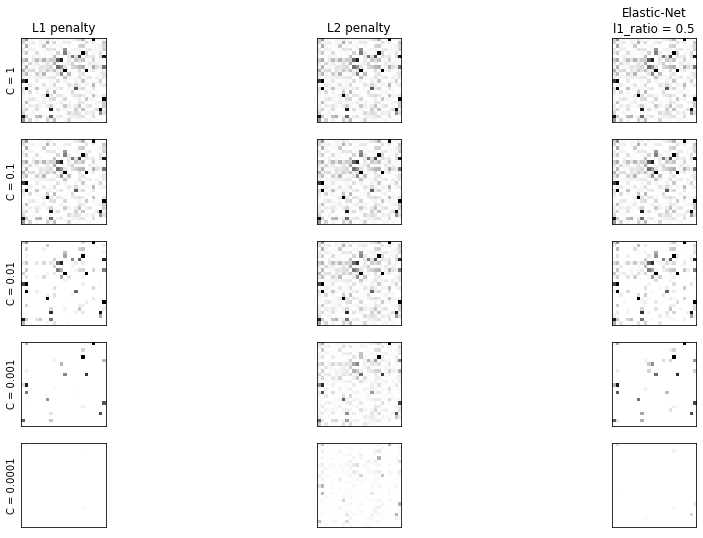

Wall time: 2min 37s


In [27]:
%%time

l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 9))

# Set regularization parameter
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01, 0.001, 0.0001), axes)):
    
    LR_L1 = LogisticRegression(C=C, penalty='l1', solver='saga', multi_class='multinomial')
    LR_L2 = LogisticRegression(C=C, penalty='l2', solver='saga', multi_class='multinomial')
    LR_en = LogisticRegression(C=C, penalty='elasticnet', solver='saga', multi_class='multinomial', l1_ratio=l1_ratio)
    
    LR_L1.fit(X_train, y_train)
    LR_L2.fit(X_train, y_train)
    LR_en.fit(X_train, y_train)
    
    coef_l1_LR = LR_L1.coef_.ravel()
    coef_l2_LR = LR_L2.coef_.ravel()
    coef_en_LR = LR_en.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm
    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.4f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:", sparsity_en_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:", LR_L1.score(X_train, y_train)))
    print("{:<40} {:.2f}".format("Score with L2 penalty:", LR_L2.score(X_train, y_train)))
    print("{:<40} {:.2f}".format("Score with Elastic-Net penalty:", LR_en.score(X_train, y_train)), '\n')
    
    LR_L1_predictions = LR_L1.predict(X_test)
    LR_L2_predictions = LR_L2.predict(X_test)
    LR_en_predictions = LR_en.predict(X_test)
    
    print("The accuracy of penalty = L1 and C =", C,"is", 
          '{:.2%}'.format(accuracy_score(y_test, LR_L1_predictions)), '\n')
    print("The log loss of Logistic Regression prediction is", 
          '{:.2}'.format(log_loss(y_test, LR_L1.predict_proba(X_test))), '\n')
    print(classification_report(y_test, LR_L1_predictions), '\n')
    
    print("The accuracy of penalty = L2 and C =", C," is", 
          '{:.2%}'.format(accuracy_score(y_test, LR_L2_predictions)), '\n')
    print("The log loss of Logistic Regression prediction is", 
          '{:.2}'.format(log_loss(y_test, LR_L2.predict_proba(X_test))), '\n')        
    print(classification_report(y_test, LR_L2_predictions), '\n')
    
    print("The accuracy of Elastic-Net and C =", C," is", 
          '{:.2%}'.format(accuracy_score(y_test, LR_en_predictions)), '\n')
    print("The log loss of Logistic Regression prediction is", 
          '{:.2}'.format(log_loss(y_test, LR_en.predict_proba(X_test))), '\n')
    print(classification_report(y_test, LR_en_predictions), '\n')   
    
    if i == 0:
        axes_row[0].set_title("L1 penalty")
        axes_row[1].set_title("L2 penalty")
        axes_row[2].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)

    for ax, coefs in zip(axes_row, [coef_l1_LR, coef_l2_LR, coef_en_LR]):
        ax.imshow(np.abs(coefs.reshape((24, 24))), 
                  interpolation='nearest',
                  cmap='binary', vmax=1, vmin=0)
        ax.set_xticks(())
        ax.set_yticks(())

    axes_row[0].set_ylabel('C = %s' % C)

plt.show()

### Grid search Cross Validation to select best params
#### Logistic (Lasso) Regression with Cross Validation

In [30]:
%%time

cvalues = [float(x) for x in [1, .1, .01, .001, .0001]]
lr1CV = LogisticRegressionCV(Cs = cvalues, penalty = 'l1', solver = 'saga', multi_class = 'multinomial')
lr1CV = lr1CV.fit(X_train, y_train)
lr1CV_predictions = lr1CV.predict(X_test)

Wall time: 5min 24s


#### Accuracy of Logistic (Lasso) Regression with Cross Validation

In [31]:
print("The accuracy of Logistic Regression L1 CV prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, lr1CV_predictions)))
print("The best Lambda for each class is", lr1CV.C_)

The accuracy of Logistic Regression L1 CV prediction is 88.63%
The best Lambda for each class is [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


#### Summarization of feature importance

In [32]:
importance = lr1CV.coef_[0]
importance_score = []

for i, v in enumerate(importance):
    importance_score.append(v)
    
importance_table = pd.DataFrame([features_cleaned, importance_score]).T
importance_table.columns = ['features_cleaned', 'importance_score']
importance_table = importance_table.sort_values('importance_score')
importance_table

,features_cleaned,importance_score
1,NumItems,-0.570946
49,PHARMACY OTC,-0.422686
17,DSD GROCERY,-0.363963
47,PERSONAL CARE,-0.281852
54,PRODUCE,-0.277289
...,...,...
63,WIRELESS,0
0,Weekday,0.134844
37,LARGE HOUSEHOLD GOODS,0.198369
31,IMPULSE MERCHANDISE,0.57716


#### Log Loss of Logistic Regression

In [33]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(y_test, lr1CV.predict_proba(X_test))))

The log loss of Logistic Regression prediction is 0.49


#### Confusion Matrix on Logistic (Lasso) Regression with Cross Validation

In [34]:
pd.crosstab(index = y_test,
            columns = lr1CV_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,727,1,0,1,0,0,1,0,0
5,1,607,6,2,1,5,20,6,5
24,5,16,401,13,1,11,16,12,10
25,1,15,3,700,4,7,15,12,8
32,2,2,5,7,336,12,10,1,13
35,0,7,4,3,1,321,5,15,37
36,3,37,11,13,5,5,531,6,9
37,1,6,11,2,2,11,6,488,30
38,2,9,8,4,3,39,15,32,504


#### Classification Report on Logistic (Lasso) Regression with Cross Validation

In [35]:
print(classification_report(y_test, lr1CV_predictions), '\n')

              precision    recall  f1-score   support

           3       0.98      1.00      0.99       730
           5       0.87      0.93      0.90       653
          24       0.89      0.83      0.86       485
          25       0.94      0.92      0.93       765
          32       0.95      0.87      0.91       388
          35       0.78      0.82      0.80       393
          36       0.86      0.86      0.86       620
          37       0.85      0.88      0.86       557
          38       0.82      0.82      0.82       616

    accuracy                           0.89      5207
   macro avg       0.88      0.88      0.88      5207
weighted avg       0.89      0.89      0.89      5207
 



#### Logistic (Ridge) Regression with Cross Validation

In [36]:
%%time

cvalues = [float(x) for x in [1, .1, .01, .001, .0001]]
lr2CV = LogisticRegressionCV(Cs = cvalues, penalty = 'l2', solver = 'lbfgs', multi_class = 'multinomial')
lr2CV = lr2CV.fit(X_train, y_train)
lr2CV_predictions = lr2CV.predict(X_test)

Wall time: 52.7 s


#### Accuracy of Logistic (Ridge) Regression with Cross Validation

In [37]:
print("The accuracy of Logistic Regression L2 CV prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, lr2CV_predictions)))
print("The best Lambda for each class is", lr2CV.C_)

The accuracy of Logistic Regression L2 CV prediction is 89.28%
The best Lambda for each class is [1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Summarization of feature importance

In [38]:
importance = lr2CV.coef_[0]
importance_score = []

for i, v in enumerate(importance):
    importance_score.append(v)
    
importance_table = pd.DataFrame([features_cleaned, importance_score]).T
importance_table.columns = ['features_cleaned', 'importance_score']
importance_table = importance_table.sort_values('importance_score')
importance_table

,features_cleaned,importance_score
15,COOK AND DINE,-2.12744
1,NumItems,-1.56491
33,INFANT CONSUMABLE HARDLINES,-1.44819
26,HOME DECOR,-1.28486
54,PRODUCE,-1.073
...,...,...
41,MEDIA AND GAMING,0.439256
25,HARDWARE,0.48443
31,IMPULSE MERCHANDISE,1.52173
37,LARGE HOUSEHOLD GOODS,3.77558


#### Log Loss of Logistic Regression

In [39]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(y_test, lr2CV.predict_proba(X_test))))

The log loss of Logistic Regression prediction is 0.42


#### Confusion Matrix on Logistic (Ridge) Regression with Cross Validation

In [40]:
pd.crosstab(index = y_test,
            columns = lr2CV_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,727,0,1,1,1,0,0,0,0
5,1,607,5,1,1,5,22,6,5
24,3,10,425,10,1,7,12,7,10
25,3,8,1,722,3,4,6,11,7
32,1,4,3,7,337,9,10,2,15
35,0,8,3,4,2,322,6,14,34
36,5,38,12,16,6,6,522,6,9
37,1,6,9,2,2,13,4,490,30
38,2,9,10,4,3,44,15,32,497


#### Classification Report on Logistic (Ridge) Regression with Cross Validation

In [41]:
print(classification_report(y_test, lr1CV_predictions), '\n')

              precision    recall  f1-score   support

           3       0.98      1.00      0.99       730
           5       0.87      0.93      0.90       653
          24       0.89      0.83      0.86       485
          25       0.94      0.92      0.93       765
          32       0.95      0.87      0.91       388
          35       0.78      0.82      0.80       393
          36       0.86      0.86      0.86       620
          37       0.85      0.88      0.86       557
          38       0.82      0.82      0.82       616

    accuracy                           0.89      5207
   macro avg       0.88      0.88      0.88      5207
weighted avg       0.89      0.89      0.89      5207
 



### Supervised Learning - Naive Bayes

In [43]:
nb = GaussianNB()
nb = nb.fit(X_train, y_train)
nb_predictions = nb.predict(X_test)

#### Accuracy of Naive Bayes

In [45]:
print("The accuracy of Naive Bayes prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, nb_predictions)))

The accuracy of Naive Bayes prediction is 53.47%


#### Log Loss of Naive Bayes

In [53]:
print("The log loss of Naive Bayes prediction is", 
      '{:.2}'.format(log_loss(y_test, nb.predict_proba(X_test))))

The log loss of Naive Bayes prediction is 1.1e+01


#### Confusion Matrix on Naive Bayes

In [47]:
pd.crosstab(index = y_test,
            columns = nb_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,673,0,4,1,5,40,2,2,3
5,187,196,10,4,4,216,18,10,8
24,19,7,338,7,3,61,34,9,7
25,6,88,38,504,27,38,27,15,22
32,1,1,14,8,211,115,12,5,21
35,16,2,2,3,8,341,6,2,13
36,12,185,27,20,12,150,168,6,40
37,0,3,11,6,3,265,2,163,104
38,1,4,11,6,6,385,2,11,190


#### Classification Report on Naive Bayes

In [48]:
print(classification_report(y_test, nb_predictions), '\n')

              precision    recall  f1-score   support

           3       0.74      0.92      0.82       730
           5       0.40      0.30      0.34       653
          24       0.74      0.70      0.72       485
          25       0.90      0.66      0.76       765
          32       0.76      0.54      0.63       388
          35       0.21      0.87      0.34       393
          36       0.62      0.27      0.38       620
          37       0.73      0.29      0.42       557
          38       0.47      0.31      0.37       616

    accuracy                           0.53      5207
   macro avg       0.62      0.54      0.53      5207
weighted avg       0.63      0.53      0.54      5207
 



### Supervised Learning - Decision Tree

In [49]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)

#### Accuracy of Decision Tree

In [50]:
print("The accuracy of Decision Tree prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, dt_predictions)))

The accuracy of Decision Tree prediction is 83.08%


#### Log Loss of Decision Tree

In [54]:
print("The log loss of Decision Tree prediction is", 
      '{:.2}'.format(log_loss(y_test, dt.predict_proba(X_test))))

The log loss of Decision Tree prediction is 5.7


#### Confusion Matrix Decision Tree

In [51]:
pd.crosstab(index = y_test,
            columns = dt_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,724,1,1,0,0,1,3,0,0
5,2,576,9,4,2,6,33,6,15
24,2,8,386,16,2,10,21,16,24
25,2,12,22,652,11,16,23,14,13
32,1,3,9,12,323,8,15,8,9
35,0,14,6,10,3,277,8,26,49
36,0,45,15,28,16,9,479,8,20
37,0,8,13,2,7,23,5,452,47
38,1,11,17,9,7,53,14,47,457


#### Classification Report on Decision Tree

In [52]:
print(classification_report(y_test, dt_predictions), '\n')

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       730
           5       0.85      0.88      0.87       653
          24       0.81      0.80      0.80       485
          25       0.89      0.85      0.87       765
          32       0.87      0.83      0.85       388
          35       0.69      0.70      0.70       393
          36       0.80      0.77      0.78       620
          37       0.78      0.81      0.80       557
          38       0.72      0.74      0.73       616

    accuracy                           0.83      5207
   macro avg       0.82      0.82      0.82      5207
weighted avg       0.83      0.83      0.83      5207
 



### Supervised Learning - Random Forest

In [58]:
rf = RandomForestClassifier(n_estimators = 9, criterion = 'entropy')
rf = rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

#### Accuracy of Random Forest

In [59]:
print("The accuracy of Random Forest prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, rf_predictions)))

The accuracy of Random Forest prediction is 85.83%


#### Log Loss of Random Forest

In [61]:
print("The log loss of Random Forest prediction is", 
      '{:.2}'.format(log_loss(y_test, rf.predict_proba(X_test))))

The log loss of Random Forest prediction is 1.2


#### Confusion Matrix Random Forest

In [62]:
pd.crosstab(index = y_test,
            columns = rf_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,723,1,3,0,1,0,1,0,1
5,2,586,9,3,2,5,31,8,7
24,2,13,393,18,4,7,23,15,10
25,1,11,10,681,8,12,14,15,13
32,1,2,2,9,342,7,13,4,8
35,0,14,5,5,3,301,7,24,34
36,0,36,19,21,10,9,505,6,14
37,1,5,9,4,6,7,13,476,36
38,1,13,10,5,9,47,17,52,462


#### Classification Report on Random Forest

In [63]:
print(classification_report(y_test, rf_predictions), '\n')

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       730
           5       0.86      0.90      0.88       653
          24       0.85      0.81      0.83       485
          25       0.91      0.89      0.90       765
          32       0.89      0.88      0.88       388
          35       0.76      0.77      0.76       393
          36       0.81      0.81      0.81       620
          37       0.79      0.85      0.82       557
          38       0.79      0.75      0.77       616

    accuracy                           0.86      5207
   macro avg       0.85      0.85      0.85      5207
weighted avg       0.86      0.86      0.86      5207
 



### Supervised Learning - Support Vector Machine (SVM)

In [86]:
%%time

sv = svm.SVC(C = 1, probability = True, decision_function_shape = 'ovr')
sv = sv.fit(X_train, y_train)
sv_predictions = sv.predict(X_test)

Wall time: 2min 19s


#### Accuracy of SVM

In [87]:
print("The accuracy of SVM prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, sv_predictions)))

The accuracy of SVM prediction is 88.34%


#### Log Loss of SVM

In [88]:
print("The log loss of SVM prediction is", 
      '{:.2}'.format(log_loss(y_test, sv.predict_proba(X_test))))

The log loss of SVM prediction is 0.38


#### Confusion Matrix SVM

In [89]:
pd.crosstab(index = y_test,
            columns = sv_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,722,1,1,1,1,0,2,2,0
5,1,598,4,1,2,5,23,11,8
24,6,14,397,11,2,12,18,14,11
25,0,11,5,693,4,11,17,14,10
32,0,2,5,4,337,10,13,4,13
35,0,6,5,3,2,323,7,15,32
36,3,34,8,10,6,6,533,6,14
37,0,8,7,0,3,10,3,488,38
38,0,11,3,3,3,39,15,33,509


#### Classification Report on SVM

In [90]:
print(classification_report(y_test, sv_predictions), '\n')

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       730
           5       0.87      0.92      0.89       653
          24       0.91      0.82      0.86       485
          25       0.95      0.91      0.93       765
          32       0.94      0.87      0.90       388
          35       0.78      0.82      0.80       393
          36       0.84      0.86      0.85       620
          37       0.83      0.88      0.85       557
          38       0.80      0.83      0.81       616

    accuracy                           0.88      5207
   macro avg       0.88      0.88      0.88      5207
weighted avg       0.89      0.88      0.88      5207
 



### Supervised Learning - K-Nearest Neighbor (KNN)

In [91]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn = knn.fit(X_train, y_train)
knn_predictions =  knn.predict(X_test)

#### Accuracy of KNN

In [92]:
print("The accuracy of KNN prediction is", 
      '{:.2%}'.format(accuracy_score(y_test, knn_predictions)))

The accuracy of KNN prediction is 84.90%


#### Log Loss of kNN

In [93]:
print("The log loss of kNN prediction is", 
      '{:.2}'.format(log_loss(y_test, knn.predict_proba(X_test))))

The log loss of kNN prediction is 1.6


#### Confusion Matrix KNN

In [95]:
pd.crosstab(index = y_test,
            columns = knn_predictions,
            rownames = ['Actual'],
            colnames = ['Predicted'],
            margins = False)

Predicted,3,5,24,25,32,35,36,37,38
Actual,,,,,,,,,
3,722,3,0,1,1,0,1,2,0
5,3,588,3,1,2,8,28,11,9
24,11,17,362,11,2,12,33,18,19
25,2,14,7,636,7,20,34,21,24
32,3,3,7,9,309,18,18,4,17
35,1,6,3,2,2,326,5,15,33
36,4,41,8,11,3,9,520,11,13
37,0,9,2,1,2,16,7,464,56
38,2,9,2,0,3,48,14,44,494


#### Classification Report on KNN

In [96]:
print(classification_report(y_test, knn_predictions), '\n')

              precision    recall  f1-score   support

           3       0.97      0.99      0.98       730
           5       0.85      0.90      0.88       653
          24       0.92      0.75      0.82       485
          25       0.95      0.83      0.89       765
          32       0.93      0.80      0.86       388
          35       0.71      0.83      0.77       393
          36       0.79      0.84      0.81       620
          37       0.79      0.83      0.81       557
          38       0.74      0.80      0.77       616

    accuracy                           0.85      5207
   macro avg       0.85      0.84      0.84      5207
weighted avg       0.86      0.85      0.85      5207
 

